In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import seaborn as sns
from matplotlib.colors import ListedColormap
from nibabel.affines import apply_affine
import numpy.linalg as npl
from nilearn.reporting import get_clusters_table
from scipy.ndimage import distance_transform_edt

from nilearn.datasets import fetch_atlas_difumo
difumo_data = fetch_atlas_difumo(dimension=128, resolution_mm=2, data_dir=None, resume=True, verbose=1, legacy_format=False)
# load 4d image and fetch the first volume
difumo_4d = nib.load(difumo_data['maps'])

def get_difumo_label(world_coord):
    voxel_coord = apply_affine(npl.inv(difumo_4d.affine), world_coord).astype(int)
    max = np.max(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    argmax = np.argmax(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    location = difumo_data['labels'].iloc[argmax, :]
    return location['difumo_names'], location['yeo_networks7'], max


mars_labelmap = nib.load('../resources/MNI152_nonlin_MarsAtlas.nii.gz')
mars_labels = pd.read_csv('../resources/MarsLabels_long.csv', index_col=False)

def get_mars_label(world_coord, max_radius=30):
    voxel_coord = apply_affine(npl.inv(mars_labelmap.affine), world_coord).astype(int)
    labelmap_data = mars_labelmap.get_fdata()
    nonzero_mask = labelmap_data > 0
    # Compute distance transform
    distances, indices = distance_transform_edt(~nonzero_mask, return_indices=True)
    # Get the closest non-zero label within the max_radius
    closest_voxel_coord = indices[:, voxel_coord[0], voxel_coord[1], voxel_coord[2]]
    # Ensure the closest voxel is within max_radius
    distance_to_closest = distances[tuple(voxel_coord)]
    if distance_to_closest > max_radius:
        return 0  # Return 0 if no non-zero label is within the radius
    label = labelmap_data[closest_voxel_coord[0], closest_voxel_coord[1], closest_voxel_coord[2]]
    res = mars_labels.loc[mars_labels['Index'] == label, :].copy()
    res.loc[:, 'Distance'] = distance_to_closest
    return res
   

dir_mediation = '/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/mediation_signflipped_signedquantile_studymod_results'
data4d_harmonized = nib.load(f'{dir_mediation}/../all_data_studyranked.nii')
pheno = pd.read_csv(f'{dir_mediation}/../signatures.csv')
pheno['Rating_diff'] = -1*pheno['Rating_diff']
# get mean effect in each group for a given voxel
def get_stats(voxel_coord, stat_fun, data4d=data4d_harmonized, pheno=pheno):
    data = data4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :]
    return stat_fun(data, pheno)

def stat_fun_groupmeans(data, pheno):
    return np.mean(data[pheno['Conditioning']=='suggestions']), np.mean(data[pheno['Conditioning']=='suggestions & conditioning'])

def stat_fun_percgt0(data, pheno):
    mean_INT, mean_CONDINT = stat_fun_groupmeans(data, pheno)
    return (mean_INT+0.5)*100, (mean_CONDINT+0.5)*100 #weighted average (across studies) of the % of participants with a positive effect

my_cmp = ListedColormap(['cyan', 'blue', 'white', 'white', 'red', 'orange'])

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
mask = nib.load(f'{dir_mediation}/../full_masked_10_percent.nii')
mask_data = mask.get_fdata()

contrast = [
    "PathA(XM)",
    "PathB(MY)",
    "Indirect(ACME)",
    "Direct(Total-Indirect)",
    "INST_mean",
    "CONDINST_mean",
    "INSTandCONDINST",
    ]
img_type = ['beta', 'thres', 'uncorr_logp', 'fdr_logq']

img = {}
for c in contrast:
    img[c] = {}
    for t in img_type:
        img[c][t] = nib.load(f'{dir_mediation}/{t}_{c}.nii.gz')

(-0.09800222618622087, -5.75075972095036)

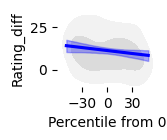

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
from matplotlib.patches import Ellipse
import matplotlib as mpl
plt.style.use('default')

def sub_cmap(cmap, vmin, vmax):
    return lambda v: cmap(vmin + (vmax - vmin) * v)

def corrs(x, y, z):
    #world to voxel
    x, y, z = apply_affine(npl.inv(img['PathB(MY)']['beta'].affine), (x, y, z)).astype(int)
    beta = img['PathB(MY)']['beta'].get_fdata()[x, y, z] 
    # calculate correlation:
    # r = beta*(std_x/std_y)
    # std_x = 1/sqrt(3) - std of the uniform distribution
    # std_y = std of the dependent variable
    correlation = beta*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std()
    fig, ax = plt.subplots(figsize=(1.3, 1))
    data = data4d_harmonized.get_fdata()[x, y, z,:]*100
    for study in pheno.Study_ID.unique():
        data[pheno.Study_ID==study] -= data[pheno.Study_ID==study].mean() # get rid of the mean
        
    if correlation > 0:
        color = 'red'
    else:
        color = 'blue'
    
    cmap = LinearSegmentedColormap.from_list("", ["white","lightgray"])
    sns.kdeplot(y=pheno['Rating_diff'], x=data, levels=3, cmap=cmap, fill=True, thresh=0.33) #levels=[0.5, 0.75], color='gray', fill=['gray', 'red'])
    sns.regplot(y=pheno['Rating_diff'], x=data, color=color, scatter=False, line_kws=dict(alpha=1)) #, x_estimator=np.mean, x_bins=np.arange(-100, 100, 50))
    plt.setp(ax.collections[1], alpha=0.3, color=color, zorder=10)
    plt.xticks([-30, 0, 30])
    #plt.yticks([5, 10, 15])
    plt.ylim(-10, 35)
    plt.xlim(-60, 60)
    plt.xlabel('Percentile from 0')
    sns.despine(left=True, bottom=True)
    return correlation, beta

# test it
corrs(-10, 0, 0)

## MricroGL scripts
We select slices with at least n_sign significant voxels

In [4]:
from nilearn.plotting import find_cut_slices

coords = find_cut_slices(img['PathB(MY)']['uncorr_logp'], direction="z", n_cuts=9)
coords = ' '.join(str(z) for z in coords)
f'A H -0.1 V -0.1 {coords} S X R 0'

'A H -0.1 V -0.1 -42.0 -30.0 -14.0 6.0 18.0 28.0 44.0 56.0 68.0 S X R 0'

In [52]:
nip.view_img(img['PathB(MY)']['thres']).open_in_browser()

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [7]:
clust_table = get_clusters_table(stat_img=img['PathB(MY)']['uncorr_logp'],
                                 stat_threshold=-np.log10(0.01),
                                 cluster_threshold=20, #voxels
                                 min_distance=20 #mm
                                 )

clust_table['region'] = 'N/A'
clust_table['yeo_network'] = 'N/A'

# convert pandas column type row type to int
clust_table['X'] = clust_table['X'].astype(int)
clust_table['Y'] = clust_table['Y'].astype(int)
clust_table['Z'] = clust_table['Z'].astype(int)

for i, row in clust_table.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    x_vox, y_vox, z_vox = apply_affine(npl.inv(img['PathB(MY)']['beta'].affine), (x, y, z)).astype(int)
    clust_table.loc[row.name, 'Effect size'] = img['PathB(MY)']['beta'].get_fdata()[x_vox, y_vox, z_vox] 
    # calculate correlation:
    # r = beta*(std_x/std_y)
    # std_x = 1/sqrt(3) - std of the uniform distribution
    # std_y = std of the dependent variable
    clust_table.loc[row.name, 'Correlation'] = np.round(clust_table.loc[row.name, 'Effect size']*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std(), 1)
    
    clust_table.loc[row.name, 'Direction'] = np.sign(clust_table.loc[row.name, 'Effect size'])
    
    clust_table.loc[row.name, 'Mean INST'] = np.round(img['INST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]*100+50, 1)
    clust_table.loc[row.name, 'Mean COND'] = np.round(img['CONDINST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]*100+50, 1)
    
    mars_region = get_mars_label([x, y, z])
    clust_table.loc[row.name, 'Mars region'] = mars_region['Hemisphere'].values[0] + ' ' + mars_region['Full_name'].values[0] 

    region, yeo_nw, prob = get_difumo_label([x, y, z])
    clust_table.loc[row.name, 'DiFuMo region'] = region
    clust_table.loc[row.name, 'yeo_network'] = yeo_nw

    clust_table.loc[row.name, 'Peak Stat uncorr'] = 10 ** (-row['Peak Stat'])
    if clust_table.loc[row.name, 'Peak Stat uncorr'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
    clust_table.loc[row.name, 'Peak Stat FDR'] = 10 ** (- img['PathB(MY)']['fdr_logq'].get_fdata()[x_vox, y_vox, z_vox])
    
    # delete row if peak is not fdr significant
    if clust_table.loc[row.name, 'Peak Stat FDR'] > 0.05:
        clust_table.drop(row.name, inplace=True)
        continue
    
    if clust_table.loc[row.name, 'Peak Stat FDR'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'
        

    ### specific for path A
    pgt0_INT, pgt0_CONDINT = get_stats(voxel_coord=(x_vox, y_vox, z_vox), stat_fun=stat_fun_percgt0)
    # weighted average (across studies) of the % of participants with a positive effect
    clust_table.loc[row.name, 'perc_gt0_INT'] = pgt0_INT
    clust_table.loc[row.name, 'perc_gt0_CONDINT'] = pgt0_CONDINT
    # difference in % of participants with a positive effect - when modelling sex and age
    clust_table.loc[row.name, 'perc_gt0_diff'] = pgt0_CONDINT - pgt0_INT

pd.set_option("display.precision", 5)
clust_table[['Cluster ID', 'Cluster Size (mm3)', 'X', 'Y', 'Z', 'Mean INST', 'Mean COND',
     'Effect size', 'Correlation', 'Peak Stat uncorr', 'Peak Stat FDR', 'Mars region', 'DiFuMo region', 'yeo_network', ]]

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_48102/2223270658.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_48102/2223270658.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'


,Cluster ID,Cluster Size (mm3),X,Y,Z,Mean INST,Mean COND,Effect size,Correlation,Peak Stat uncorr,Peak Stat FDR,Mars region,DiFuMo region,yeo_network
0,1,10544,64,-42,18,55.8,49.1,-9.89988,-0.2,<0.0001,<0.0001,Right Caudal Middle Temporal Cortex,Angular gyrus RH,DorsAttnB
1,1a,,50,-4,8,49.5,48.8,-9.57251,-0.2,<0.0001,<0.0001,Right Ventral Motor Cortex,Central operculum cortex,SomMotA
2,1b,,54,-18,28,51.5,42.4,-8.20811,-0.1,<0.0001,<0.0001,Right Dorsal Inferior Parietal Cortex,Supramarginal gyrus anterior RH,SalVentAttnA
3,1c,,58,-38,18,52.3,46.1,-7.84655,-0.1,<0.0001,<0.0001,Right Caudal Superior Temporal Cortex,Angular gyrus RH,DorsAttnB
4,2,520,-26,-62,10,42.7,29.4,-8.12383,-0.1,<0.0001,<0.0001,Left Rostral Medial Visual Cortex,Intracalcarine cortex,VisCent
5,3,392,-26,50,30,51.3,45.6,-8.39572,-0.1,<0.0001,<0.0001,Left Rostral Dorsolateral Superior Prefrontal ...,Superior frontal sulcus anterior,DefaultB
6,4,1160,-14,-46,70,48.7,41.0,-9.01556,-0.2,<0.0001,<0.0001,Left Dorsomedial Somatosensory Cortex,Paracentral lobule,SomMotA
7,5,808,-6,-88,6,45.5,44.9,-8.46841,-0.1,<0.0001,<0.0001,Left Cuneus,Calcarine cortex posterior,VisCent
8,6,1352,-4,-4,6,42.8,39.6,-8.04378,-0.1,<0.0001,<0.0001,Left Thalamus,Thalamus,No network found
9,7,648,2,-66,-24,40.1,34.1,-9.80946,-0.2,<0.0001,<0.0001,Right Caudal Medial Visual Cortex,Cerebellum VI anterior,No network found


((-0.14909124585667624, -8.748657706914722), 0.009549925860214359)

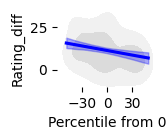

In [342]:
corrs(2, -20, -30), 10**-2.02 # Brainstem


((0.15766472262244857, 9.251748368951535),
 0.06426877173170198,
     Index  Label Hemisphere     Lobe/Region                       Full_name  \
 79    139  PFCvm      Right  Orbito-Frontal  Ventromedial Prefrontal Cortex   
 
    Brodman_Area  Distance  
 79     32/10/11  1.414214  )

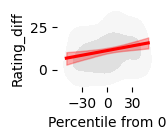

In [343]:
corrs(10, 26, -14), 10**-1.192, get_mars_label((10, 26, -14)) # Brainstem

(-0.160106115599909, -9.395009037041996)

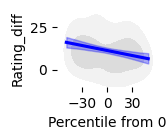

In [330]:
corrs(30.0,-4.0,-14.0) #16,464,30.0,-4.0,-14.0,0.453664,0.436960,-9.395009,-0.160106,<0.0001,<0.0001,Right Amygdala,Hippocampal fissure,No network found


(-0.18664104137626772, -10.952075527175932)

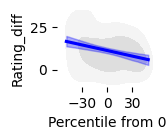

In [331]:
corrs(10.0,-16.0,6.0) # 22,1304,10.0,-16.0,6.0,0.532804,0.514550,-10.952076,-0.186641,<0.0001,0.000725,Right Thalamus,Thalamus,No network found

(-0.16313098774573767, -9.572508197767204)

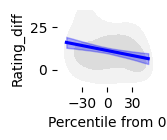

In [332]:
corrs(50.0,-4.0,8.0) # 1a,"",50.0,-4.0,8.0,0.494507,0.487576,-9.572508,-0.163131,<0.0001,<0.0001,Right Ventral Motor Cortex,Central operculum cortex,SomMotA


(-0.1669222401834122, -9.794978468688447)

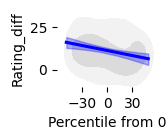

In [333]:
corrs(40.0,-22.0,22.0) # 15,1272,40.0,-22.0,22.0,0.441957,0.405507,-9.794978,-0.166922,<0.0001,<0.0001,Right Ventral Inferior Parietal Cortex,Central operculum cortex,SomMotA -> post-insula


(-0.13987941959954583, -8.20810876779943)

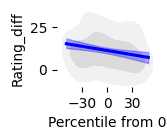

In [334]:
corrs(54.0,-18.0,28.0) # 2,1b,"",54.0,-18.0,28.0,0.515167,0.424427,-8.208109,-0.139879,<0.0001,<0.0001,Right Dorsal Inferior Parietal Cortex,Supramarginal gyrus anterior RH,SalVentAttnA


(-0.1769404631126267, -10.382846674736694)

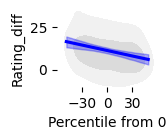

In [336]:
corrs(8.0,-8.0,44.0) # 12b,"",8.0,-8.0,44.0,0.340709,0.282534,-10.382847,-0.176940,<0.0001,<0.0001,Right Mid Cingulate Cortex,Paracingulate gyrus postero-inferior,SomMotA


(-0.16918394659140132, -9.927695148888798)

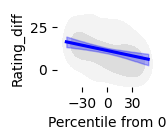

In [337]:
corrs(22.0,-42.0,66.0) # 13,1968,22.0,-42.0,66.0,0.445813,0.426274,-9.927695,-0.169184,<0.0001,<0.0001,Right Dorsomedial Somatosensory Cortex,Superior precentral and postcentral sulci posterior,SomMotA


(-0.1711938089881654, -10.045633650551007)

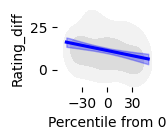

In [338]:
corrs(4.0,4.0,66.0) # 12a,"",4.0,4.0,66.0,0.478816,0.447454,-10.045634,-0.171194,<0.0001,<0.0001,Right Dorsomedial Premotor Cortex,Paracingulate gyrus postero-superior,SalVentAttnA


(-0.16870809056286584, -9.89977197011658)

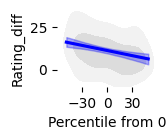

In [339]:
corrs(30.0,-18.0,64.0) # 20,880,30.0,-18.0,64.0,0.469283,0.412790,-9.899772,-0.168708,<0.0001,<0.0001,Right Dorsomedial Motor Cortex,Postcentral gyrus RH,SomMotA


In [345]:
9*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std()

0.15337452414552052